In [20]:
import os

import numpy as np
import pandas as pd

In [2]:
data_path = "../data/combined/"
models_path = "mlp/"
data_file = "amplitude_csi_dataframe.pkl"


DISCRETE_VARIABLES = ["person"]
TARGET_VARIABLE = "position"
STATE = 42

data_df: pd.DataFrame = pd.read_pickle(data_path + data_file)

# Convert all column names to strings
data_df.columns = data_df.columns.astype(str)
state_files = [
    models_path + file for file in os.listdir(models_path) if file.endswith(".pth")
]

print(state_files)
print(data_df.head())

['mlp/mlp_model.pth', 'mlp/model_epoch_10.pth', 'mlp/model_epoch_107.pth', 'mlp/model_epoch_134.pth', 'mlp/model_epoch_148.pth', 'mlp/model_epoch_155.pth', 'mlp/model_epoch_163.pth', 'mlp/model_epoch_19.pth', 'mlp/model_epoch_194.pth', 'mlp/model_epoch_208.pth', 'mlp/model_epoch_216.pth', 'mlp/model_epoch_229.pth', 'mlp/model_epoch_250.pth', 'mlp/model_epoch_268.pth', 'mlp/model_epoch_28.pth', 'mlp/model_epoch_39.pth', 'mlp/model_epoch_46.pth', 'mlp/model_epoch_59.pth', 'mlp/model_epoch_69.pth', 'mlp/model_epoch_72.pth', 'mlp/model_epoch_88.pth']
   person  position            6            7            8            9  \
0       1        17   795.910156   849.388000   890.166809   912.882263   
1       1        17   798.279419   843.614258   868.484314   895.013977   
2       1        17  1064.543091  1086.945312  1105.320312  1135.975342   
3       1        17  1060.771362  1092.156128  1112.137573  1130.086670   
4       1        17  1329.939087  1409.457397  1416.469604  1432.482056 

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

numerical_columns = [
    col
    for col in data_df.columns
    if col not in DISCRETE_VARIABLES and col != TARGET_VARIABLE
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_columns),
        ("cat", "passthrough", DISCRETE_VARIABLES),
    ]
)

X = data_df.drop(columns=[TARGET_VARIABLE])
X = preprocessor.fit_transform(X)
y = data_df[TARGET_VARIABLE]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=STATE
)

print(X_train[:5])
print(y_train[:5])
print(X_test[:5])
print(y_test[:5])

[[ 0.38642046  0.29976055  0.21416575 ...  2.7544522  -0.07609867
  44.        ]
 [-0.69760364 -0.6823467  -0.6444642  ... -0.4048676  -0.7114199
  26.        ]
 [-0.6339469  -0.64925706 -0.6274046  ... -0.6062821   0.19943404
  52.        ]
 [-0.88174653 -0.9246833  -0.8360618  ... -0.37353423 -0.69077873
   8.        ]
 [ 1.1035314   1.0955558   1.1070964  ... -0.4393156   0.4879667
  49.        ]]
1559868    17
903800     12
1865988     8
277030      7
1732226    13
Name: position, dtype: uint8
[[-0.21375568 -0.2730182  -0.200793   ... -0.86679655 -0.8598902
  46.        ]
 [-1.2045823  -1.1377039  -1.172124   ...  0.9736769  -0.10447231
  10.        ]
 [-1.7443719  -1.7738211  -1.8353074  ... -0.5750575  -0.17337221
  33.        ]
 [-1.4034363  -1.4370869  -1.4509764  ... -0.74591374 -0.72425234
  56.        ]
 [-1.1189996  -1.1041296  -1.0781889  ... -0.5311101  -0.33968678
  32.        ]]
1625434    13
323710     10
1151379     0
1993553     1
1135407     3
Name: position, dtype:

In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset

inputs = 235
batch_size = 512
num_workers = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert the data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

print(test_loader.dataset.tensors)

(tensor([[-0.2138, -0.2730, -0.2008,  ..., -0.8668, -0.8599, 46.0000],
        [-1.2046, -1.1377, -1.1721,  ...,  0.9737, -0.1045, 10.0000],
        [-1.7444, -1.7738, -1.8353,  ..., -0.5751, -0.1734, 33.0000],
        ...,
        [ 1.3852,  1.5208,  1.3748,  ..., -0.7631, -0.7330, 35.0000],
        [-0.8822, -0.9156, -0.8782,  ..., -0.3215, -0.3142, 56.0000],
        [-0.1381, -0.1438, -0.1963,  ..., -0.2815, -0.6353, 43.0000]]), tensor([13, 10,  0,  ..., 16,  3,  5]))


In [5]:
from dataclasses import dataclass

from mlp import CsiNeuralNet


@dataclass
class Prediction:
    name: str
    model: CsiNeuralNet
    prediction: list[int]
    target: list[int]
    accuracy: float


predictions: list[Prediction] = []

best_accuracy = 0
for state_file in state_files:
    net = CsiNeuralNet(inputs, device, state_file)
    print(state_file)
    prediction, accuracy = net.test_model(test_loader)
    print()

    prediction_obj = Prediction(
        state_file,
        net,
        prediction,
        y_test.to_list(),
        accuracy,
    )
    predictions.append(prediction_obj)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_prediction = prediction_obj

print(f"Best model: {best_prediction.name}")
print(f"Best accuracy: {best_prediction.accuracy * 100:.2f}%")

c:\Users\gurgel\Desktop\Personal\Projects\UFF\Mestrado\Telecom\csi\models\mlp.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(state_file

mlp/mlp_model.pth
Testing on device: cuda
Accuracy: 78.26%, In 8.80s

mlp/model_epoch_10.pth
Testing on device: cuda
Accuracy: 77.11%, In 8.68s

mlp/model_epoch_107.pth
Testing on device: cuda
Accuracy: 78.94%, In 9.31s

mlp/model_epoch_134.pth
Testing on device: cuda
Accuracy: 77.74%, In 9.77s

mlp/model_epoch_148.pth
Testing on device: cuda
Accuracy: 78.90%, In 10.05s

mlp/model_epoch_155.pth
Testing on device: cuda
Accuracy: 78.72%, In 9.67s

mlp/model_epoch_163.pth
Testing on device: cuda
Accuracy: 78.83%, In 9.92s

mlp/model_epoch_19.pth
Testing on device: cuda
Accuracy: 80.71%, In 10.25s

mlp/model_epoch_194.pth
Testing on device: cuda
Accuracy: 78.10%, In 10.50s

mlp/model_epoch_208.pth
Testing on device: cuda
Accuracy: 79.14%, In 9.91s

mlp/model_epoch_216.pth
Testing on device: cuda
Accuracy: 78.90%, In 10.35s

mlp/model_epoch_229.pth
Testing on device: cuda
Accuracy: 77.85%, In 10.50s

mlp/model_epoch_250.pth
Testing on device: cuda
Accuracy: 78.66%, In 10.86s

mlp/model_epoc

              0       1       2       3       4       5       6       7   \
Accuracy  97.40%  91.38%  90.35%  69.21%  92.53%  91.37%  80.32%  81.08%   

              8       9       10      11      12      13      14      15  \
Accuracy  84.90%  84.74%  94.81%  95.66%  96.39%  95.94%  79.21%  41.51%   

              16      17  
Accuracy  47.25%  48.74%  


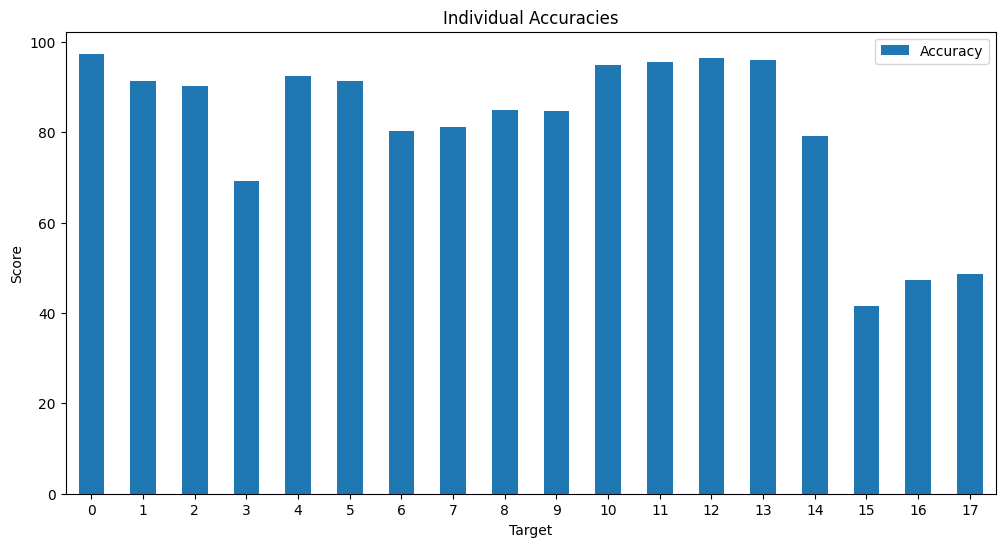

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

individual_accuracies = {}
individual_recalls = {}

for target in range(18):
    target_predictions = []
    target_actuals = []
    target_indices = [i for i, t in enumerate(best_prediction.target) if t == target]

    for i in target_indices:
        target_predictions.append(best_prediction.prediction[i])
        target_actuals.append(best_prediction.target[i])

    if target_actuals:
        individual_accuracies[target] = (
            accuracy_score(target_actuals, target_predictions) * 100
        )

data = {"Accuracy": individual_accuracies}
df = pd.DataFrame(data)
df_plot = df.copy()

df["Accuracy"] = df["Accuracy"].map("{:.2f}%".format)
print(df.T)

df_plot.plot(kind="bar", figsize=(12, 6))
plt.title("Individual Accuracies")
plt.xlabel("Target")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()

In [38]:
num_positions = 18
sum_probabilities = [0.0] * num_positions
sum_correct_probabilities = [0.0] * num_positions
sum_wrong_probabilities = [0.0] * num_positions
prediction_counts = [0] * num_positions
correct_counts = [0] * num_positions
wrong_counts = [0] * num_positions

for x, y in zip(X_test, y_test):
    state = torch.tensor([x], dtype=torch.float32).to(device)
    best_prediction.model.to(device)
    probabilities = best_prediction.model.get_position_probabilities(state)

    max_prob = max(probabilities)
    prediction = probabilities.index(max_prob)
    prediction_counts[prediction] += 1
    sum_probabilities[prediction] += max_prob

    if prediction == y:
        sum_correct_probabilities[prediction] += max_prob
        correct_counts[prediction] += 1
    else:
        sum_wrong_probabilities[prediction] += max_prob
        wrong_counts[prediction] += 1

average_total_probabilities = []
average_correct_probabilities = []
average_wrong_probabilities = []

for i in range(num_positions):
    average_total_probabilities.append(
        sum_probabilities[i] / prediction_counts[i] if prediction_counts[i] != 0 else 0
    )
    average_correct_probabilities.append(
        sum_correct_probabilities[i] / correct_counts[i]
        if correct_counts[i] != 0
        else 0
    )
    average_wrong_probabilities.append(
        sum_wrong_probabilities[i] / wrong_counts[i] if wrong_counts[i] != 0 else 0
    )

print(average_total_probabilities)
print(average_correct_probabilities)
print(average_wrong_probabilities)

[0.9796783536787973, 0.9309131788723496, 0.9318741540466963, 0.8324109899175212, 0.9475568573173341, 0.9378398791454471, 0.8823009978860726, 0.873542140603879, 0.9006262348307321, 0.8819853257002871, 0.9691303919567557, 0.9721020114196468, 0.970704210408339, 0.9685737745632984, 0.8805240372797648, 0.6584957228059215, 0.6814034744001654, 0.7284959684938539]
[0.9882120842094275, 0.9589746449343766, 0.9605847484442086, 0.8857751312883672, 0.963573630235175, 0.9549350715467981, 0.9186266916391721, 0.9121845593071605, 0.9308464314968261, 0.9258496258234452, 0.9814175345541123, 0.984635999162741, 0.9868490012332725, 0.9831966649696169, 0.93110817773768, 0.7128258413055314, 0.7351918187832062, 0.7961497958131016]
[0.779804905344037, 0.7407892831462495, 0.7402010097813717, 0.7005751495448126, 0.7424041733099864, 0.7352290883677624, 0.7042505027135405, 0.6895087688697237, 0.7110841199558171, 0.7080733553231275, 0.7486913417283512, 0.7427589850511379, 0.7545534778158465, 0.7372573861609814, 0.68

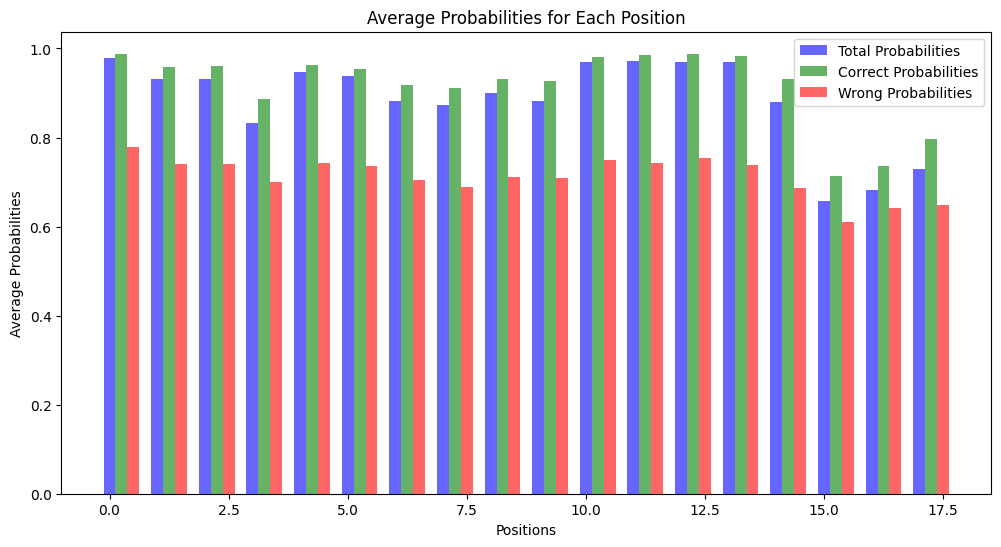

In [45]:
bar_width = 0.25

positions = np.arange(num_positions)
positions_total = positions
positions_correct = positions + bar_width
positions_wrong = positions + 2 * bar_width

plt.figure(figsize=(12, 6))
plt.bar(
    positions_total,
    average_total_probabilities,
    width=bar_width,
    color="blue",
    alpha=0.6,
    label="Total Probabilities",
)
plt.bar(
    positions_correct,
    average_correct_probabilities,
    width=bar_width,
    color="green",
    alpha=0.6,
    label="Correct Probabilities",
)
plt.bar(
    positions_wrong,
    average_wrong_probabilities,
    width=bar_width,
    color="red",
    alpha=0.6,
    label="Wrong Probabilities",
)
plt.xlabel("Positions")
plt.ylabel("Average Probabilities")
plt.title("Average Probabilities for Each Position")
plt.legend()
plt.show()

In [52]:
num_bins = 101

total_bins = [0] * num_bins
total_correct_bins = [0] * num_bins
total_accuracy_bins = [0] * num_bins

pos_bins = [[0] * num_bins for _ in range(num_positions)]
pos_correct_bins = [[0] * num_bins for _ in range(num_positions)]
pos_accuracy_bins = [[0] * num_bins for _ in range(num_positions)]

for x, y in zip(X_test, y_test):
    state = torch.tensor([x], dtype=torch.float32).to(device)
    best_prediction.model.to(device)
    probabilities = best_prediction.model.get_position_probabilities(state)

    max_prob = max(probabilities)
    prediction = probabilities.index(max_prob)

    bin_index = int(max_prob * 100)
    total_bins[bin_index] += 1
    pos_bins[prediction][bin_index] += 1

    if prediction == y:
        total_correct_bins[bin_index] += 1
        pos_correct_bins[prediction][bin_index] += 1
    
for i in range(num_bins):
    total_accuracy_bins[i] = total_correct_bins[i] / total_bins[i] if total_bins[i] != 0 else 0
    for j in range(num_positions):
        pos_accuracy_bins[j][i] = (
            pos_correct_bins[j][i] / pos_bins[j][i] if pos_bins[j][i] != 0 else 0
        )

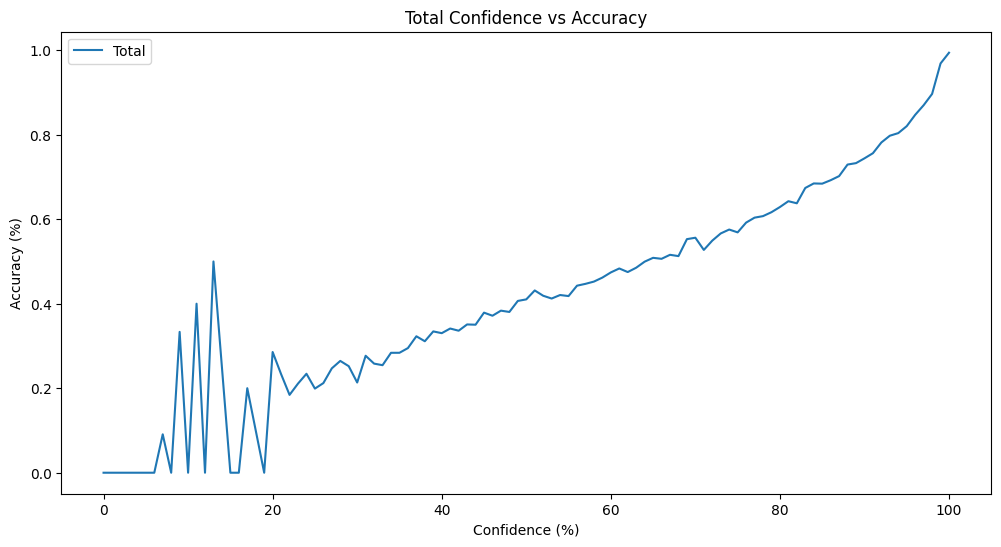

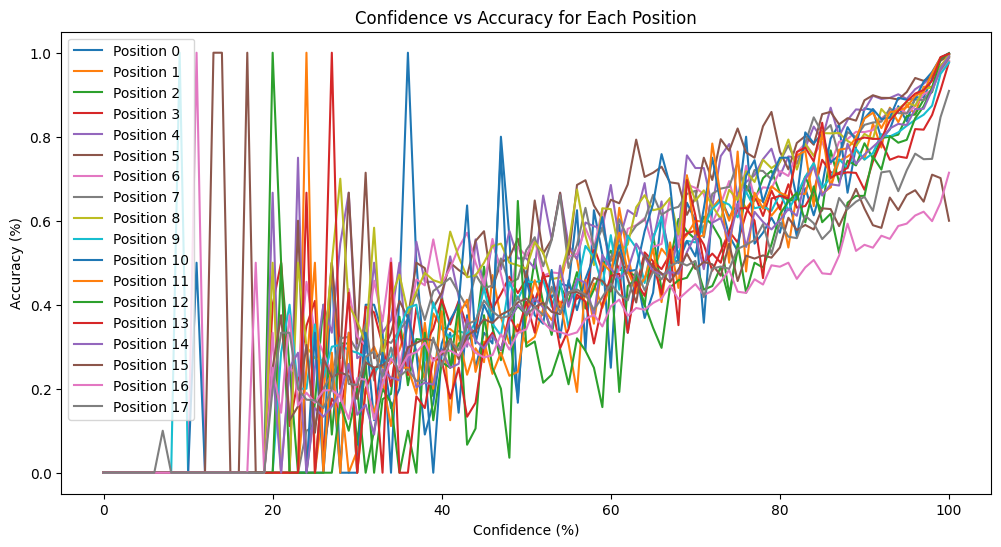

In [54]:
# Plot the total confidence/accuracy relation
plt.figure(figsize=(12, 6))
plt.plot(range(num_bins), total_accuracy_bins, label="Total")
plt.xlabel("Confidence (%)")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Total Confidence vs Accuracy")
plt.show()

# Plot the confidence/accuracy relation for each individual position
plt.figure(figsize=(12, 6))
for pos in range(num_positions):
    plt.plot(range(num_bins), pos_accuracy_bins[pos], label=f"Position {pos}")
plt.xlabel("Confidence (%)")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Confidence vs Accuracy for Each Position")
plt.show()

In [6]:
model = best_prediction.model

input_to_hidden1_weights = model.fc1.weight.data
hidden1_to_hidden2_weights = model.fc2.weight.data
hidden2_to_output_weights = model.output.weight.data

impact_matrix = torch.matmul(
    hidden2_to_output_weights,
    torch.matmul(hidden1_to_hidden2_weights, input_to_hidden1_weights),
)

# Convert the impact matrix to a numpy array for easier analysis
impact_matrix = impact_matrix.cpu().numpy()

# Print the impact matrix
print("Impact matrix (rows: output nodes, columns: input nodes):")
print(f"Shape: {impact_matrix.shape}")
print(impact_matrix)

# Identify the most impactful input nodes for each output node
most_impactful_inputs = impact_matrix.argmax(axis=1)
print("Most impactful input nodes for each output node:")
print(most_impactful_inputs)

Impact matrix (rows: output nodes, columns: input nodes):
Shape: (18, 235)
[[-3.9376236e+01 -6.9816887e+01 -5.3242901e+01 ... -1.0838344e+00
  -9.0861263e+00 -1.6595903e+01]
 [-9.5347122e+01 -8.4214951e+01 -7.0434952e+01 ... -1.8896344e+00
   1.3187125e+00 -4.4759815e+01]
 [-1.0482070e+02 -7.6494064e+01 -6.4570641e+01 ... -4.7262540e+00
  -5.4926028e+00 -1.4830351e-02]
 ...
 [-3.3426529e+01 -2.0882332e+01 -1.7408512e+01 ...  2.8237367e-01
   4.3856692e-01 -1.8248451e+01]
 [-2.6952642e+01 -2.3117153e+01 -1.5321641e+01 ...  1.2916863e-01
  -8.0229241e-01 -1.8450209e+01]
 [ 5.7817265e+01  3.6902576e+01  1.6672466e+01 ... -2.6024923e+00
  -1.2807512e+00 -3.3240868e+01]]
Most impactful input nodes for each output node:
[36 50 45 28 36 40 51  0 21  0  7 27  7 44  7 27 11  0]


#### Fix discrepancies with categorical values position in the input dataframe and the trained model

In [7]:
input_labels = list(data_df.drop(columns=[TARGET_VARIABLE]).columns)
first_column = input_labels.pop(0)
input_labels.append(first_column)

print(input_labels)

['6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '118', '119', '120', '121', '122', '123', '124', '125', '126', '130', '131', '132', '133', '134', '135', '136', '137', '138', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '168', '169', '170', '1

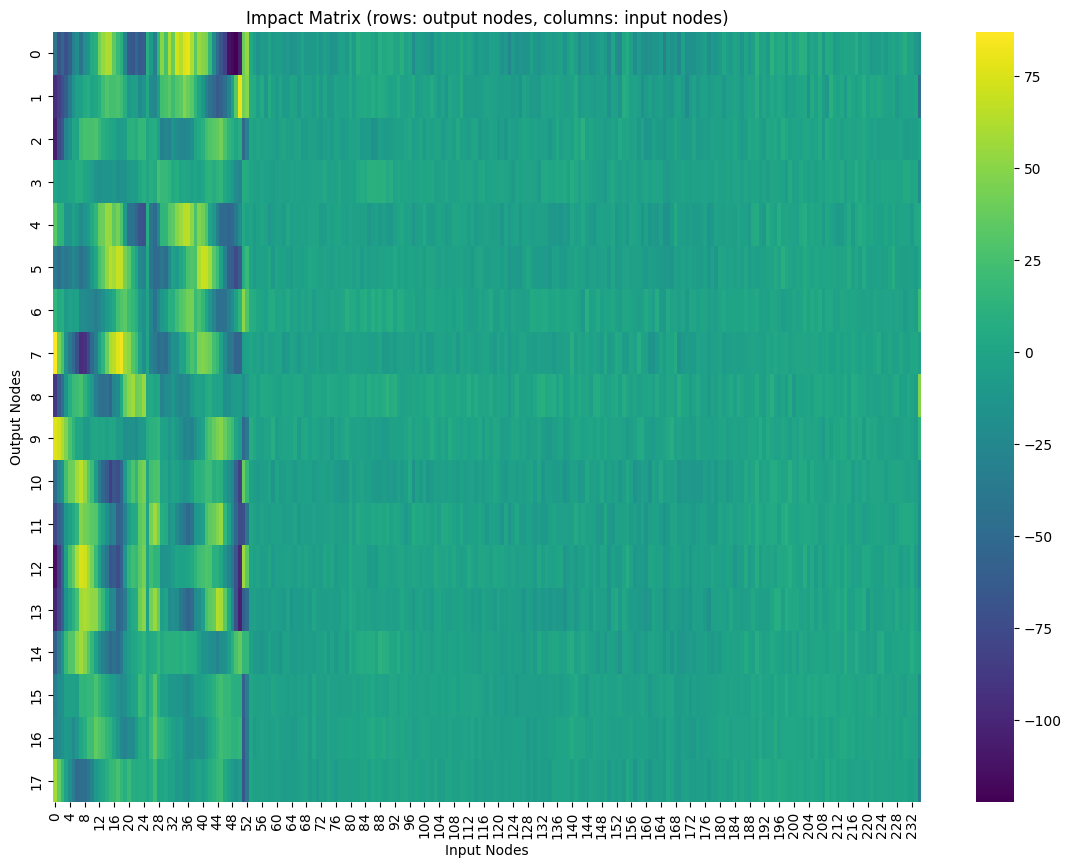

In [8]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    impact_matrix,
    annot=False,
    cmap="viridis",
    cbar=True,
    # xticklabels=input_labels,
)
plt.title("Impact Matrix (rows: output nodes, columns: input nodes)")
plt.xlabel("Input Nodes")
plt.ylabel("Output Nodes")
plt.show()